# Dataset generation

## 1. Import

In [21]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp
from torch_geometric.utils.convert import from_networkx
import pickle


## 2. Utils

In [22]:
def draw(graph, ax):
    """
    Draws the graph as a matplotlib plot.
    Depots are colored in red. Edges that have been
    traveresed
    """

    # draw nodes according to color and position attribute
    pos = nx.get_node_attributes(graph, "coordinates")
    nx.draw_networkx_nodes(
        graph, pos, ax=ax, node_size=100
    )
    labels_pos = {k: (v + np.array([0, 0.03])) for k, v in pos.items()}
    nx.draw_networkx_labels(
        graph, labels_pos, ax=ax
    )

    # draw edges
    nx.draw_networkx_edges(graph, pos)

## 3. Generating Distance Matrices

In [23]:
def build_graph(num_nodes):
    k = num_nodes // 2
    G = nx.empty_graph(num_nodes, create_using=nx.Graph())
    node_position = {
        i: coordinates for i, coordinates in enumerate(np.random.rand(num_nodes, 2))
    }
    nx.set_node_attributes(G, node_position, "coordinates")

    positions = np.array([node_position[index] for index in range(num_nodes)])
    distances = cdist(positions, positions)

    # add distance as feature vector per node
    for i in range(num_nodes):
        distance_attribute = {
            j: {f'dist{i}' : distances[i,j]} for j in range(num_nodes)
        }
        nx.set_node_attributes(G, distance_attribute)

    # add edges between nearest nodes
    edges = []
    for i in range(num_nodes):
        partition = np.argsort(distances[i])
        idx = partition[1:k+1]
        for j in range(k):
            edges.append((i,idx[j]))
    G.add_edges_from(edges)
    return G, distances

G, distances = build_graph(10)
print(G.number_of_edges())

31


## 4. Building Solutions

In [24]:
from ortools.constraint_solver import pywrapcp

# Distance callback
def get_optimal_route(distances):
    # Create a callback to calculate distances between cities.
    def create_distance_callback(dist_matrix):
        def distance_callback(from_node, to_node):
            return int(dist_matrix[from_node][to_node])
        return distance_callback

    tsp_size = distances.shape[0]
    num_vehicles = 1
    depot = 0

    # Convert distances to interger (MIP)
    dist_matrix = (10000*distances).astype(int)

    # Create routing model
    if tsp_size > 0:
        manager = pywrapcp.RoutingIndexManager(tsp_size, num_vehicles, depot)
        routing = pywrapcp.RoutingModel(manager)
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        # Create the distance callback.
        dist_callback = create_distance_callback(dist_matrix)
        transit_callback_index = routing.RegisterTransitCallback(dist_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        # Solve the problem.
        assignment = routing.SolveWithParameters(search_parameters)
        if assignment:
            # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
            route_number = 0

            # Index of the variable for the starting node.
            index = routing.Start(route_number)

            # Variable store
            route = []
            score = .0
            prev = index
            while not routing.IsEnd(index):
                # Convert variable indices to node indices in the displayed route.
                route.append(index)
                score += distances[prev, index]
                index = assignment.Value(routing.NextVar(index))
            route.append(depot)
            return route, score

route, obj = get_optimal_route(distances)
print(route, obj)

[0, 2, 9, 4, 8, 1, 3, 7, 5, 6, 0] 5.529579600158565


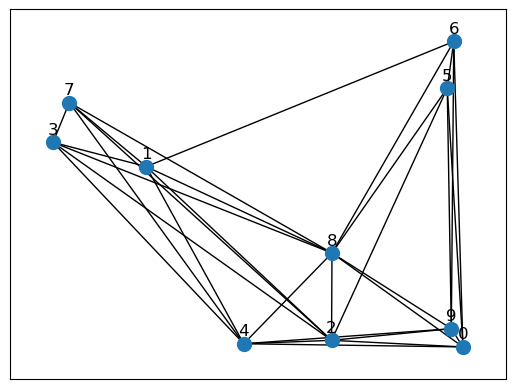

In [25]:
fig, ax = plt.subplots()
draw(G, ax)

## Generate dataset

In [29]:
def build_dataset(size, num_nodes):
    dataset = []
    for i in range(size):
        graph, dist_mat = build_graph(num_nodes)
        opt_route, opt_ojb = get_optimal_route(dist_mat)
        dataset.append(
            (from_networkx(graph), opt_route, opt_ojb)
        )
    return dataset

In [27]:
data = build_dataset(10,10)
print(data)

[(Data(edge_index=[2, 60], coordinates=[10, 2], dist0=[10], dist1=[10], dist2=[10], dist3=[10], dist4=[10], dist5=[10], dist6=[10], dist7=[10], dist8=[10], dist9=[10], num_nodes=10), [0, 8, 4, 2, 7, 9, 6, 1, 5, 3, 0], 4.157782581614059), (Data(edge_index=[2, 66], coordinates=[10, 2], dist0=[10], dist1=[10], dist2=[10], dist3=[10], dist4=[10], dist5=[10], dist6=[10], dist7=[10], dist8=[10], dist9=[10], num_nodes=10), [0, 5, 3, 2, 8, 7, 4, 1, 6, 9, 0], 3.6828845363982357), (Data(edge_index=[2, 64], coordinates=[10, 2], dist0=[10], dist1=[10], dist2=[10], dist3=[10], dist4=[10], dist5=[10], dist6=[10], dist7=[10], dist8=[10], dist9=[10], num_nodes=10), [0, 9, 4, 6, 2, 1, 3, 5, 8, 7, 0], 3.757747744314336), (Data(edge_index=[2, 60], coordinates=[10, 2], dist0=[10], dist1=[10], dist2=[10], dist3=[10], dist4=[10], dist5=[10], dist6=[10], dist7=[10], dist8=[10], dist9=[10], num_nodes=10), [0, 6, 9, 4, 8, 3, 5, 1, 2, 7, 0], 4.495111885343542), (Data(edge_index=[2, 62], coordinates=[10, 2], dis

In [28]:
with open('dataset.pkl', 'wb') as file:
    pickle.dump(data, file)